In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:

class NBADataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = self._load_data()

    def _load_data(self):
        df = pd.read_csv(self.file_path, index_col=0)
        return df

    def _add_target(self, group):
        group = pd.concat([group, group["won"].shift(-1).rename("target")], axis=1)
        return group

    def _scale_data(self, df, selected_columns):
        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])
        return df

    def _calculate_rolling_averages(self, df, selected_columns):
        rolling = df[list(selected_columns) + ["won", "team", "season"]]
        
        def find_team_averages(team):
            team[selected_columns] = team[selected_columns].rolling(10).mean()
            return team

        rolling = rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

        return rolling

    def _add_future_game_data(self, df):
        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col

        df["home_next"] = self._add_col(df, "home")
        df["team_opp_next"] = self._add_col(df, "team_opp")
        df["date_next"] = self._add_col(df, "date")

        return df

    def _add_col(self, df, col_name):
        return df.groupby("team", group_keys=False).apply(lambda x: self._shift_col(x, col_name))

    def _shift_col(self, team, col_name):
        next_col = team[col_name].shift(-1)
        return next_col

    def prepare_dataset(self):
        # Sort by date and drop irrelevant columns
        self.df = self.df.sort_values("date")
        self.df = self.df.reset_index(drop=True)
        del self.df["mp.1"]
        del self.df["mp_opp.1"]
        del self.df["index_opp"]

        #Add a target column (Whether or not team won next game)
        self.df = self.df.groupby("team", group_keys=False).apply(self._add_target)
        self.df.loc[pd.isnull(self.df["target"]), "target"] = 2
        self.df["target"] = self.df["target"].astype(int, errors="ignore")
        
        #Create copy dataframe without null values
        nulls = pd.isnull(self.df).sum()
        nulls = nulls[nulls > 0]
        valid_columns = self.df.columns[~self.df.columns.isin(nulls.index)]
        self.df = self.df[valid_columns].copy()
        
        #Convert boolean column to binary
        self.df['won'] = self.df['won'].astype(int)
        
        #Scale stat columns
        removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
        selected_columns = self.df.columns[~self.df.columns.isin(removed_columns)]
        self.df = self._scale_data(self.df, selected_columns)
        rolling = self._calculate_rolling_averages(self.df, selected_columns)
        
        rolling_cols = [f"{col}_10" for col in rolling.columns]
        rolling.columns = rolling_cols
        
        #Concatenate new columns back into dataframe, dropping null and resetting index
        self.df = pd.concat([self.df, rolling], axis=1)
        self.df = self.df.dropna()
        self.df = self.df.reset_index(drop=True)

        #Add future game data to columns
        self.df = self._add_future_game_data(self.df)
        
        self.df = self.df.merge(self.df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])
        
        # Filter columns with _x or _y suffix, excluding opp_10_x and opp_10_y, and keep 'home_next'
        suffix_columns = [col for col in self.df.columns if col.endswith(('_x', '_y')) and 'opp_10' not in col]
        additional_columns = ['home_next','date_next', 'season', 'target']
        selected_columns = suffix_columns + additional_columns
        self.df = self.df[selected_columns]

        return self.df
    
    def _extract_features(self, df):
        
        # # Extract features for team_x and team_opp_next_x
        # team_x_cols = [col for col in df.columns if '_10_x' in col and 'opp' not in col]
        # team_opp_next_x_cols = [col for col in df.columns if 'opp_10_x' in col]

        # # Concatenate features and rolling averages, including home_next
        # features_columns = team_x_cols + team_opp_next_x_cols + ["home_next"]
        
        removed_columns = list(self.df.columns[self.df.dtypes == "object"])
        selected_columns = self.df.columns[~self.df.columns.isin(removed_columns)]
        
        # Exclude columns with specific words
        excluded_words = ["season", "date", "won", "target", "team", "team_opp"]
        features_columns = [col for col in selected_columns if not any(word in col for word in excluded_words)]
        # features_columns = [col for col in features_columns if not any(word in col for word in excluded_words)]
        
        features_df = df[features_columns].copy()

        return features_df
    
    def load_training_data(self):
        season_df = self.df[["season", "target"]].copy()

        # Extract features and target using the _extract_features method
        features_df = self._extract_features(self.df)

        # Concatenate season and date columns back to features dataframe
        features_df = pd.concat([season_df, features_df], axis=1)

        # Define features and target
        target_column = "target"

        # Define features and target
        features_columns = [col for col in features_df.columns if col not in ["season", "target"]]
        
        # Separate Valideation Set
        
        # Identify the cutoff season (e.g., 2022)
        cutoff_season = 2022

        # Divide the data into training and testing sets
        train_df = features_df[features_df["season"] < cutoff_season]
        test_df = features_df[features_df["season"] == cutoff_season]

        # Extract features and target for training and testing sets
        train_features = features_df[features_columns].values
        train_target = features_df[target_column].values

        test_features = test_df[features_columns].values
        test_target = test_df[target_column].values

        # Define datasets and dataloaders for training and testing
        train_dataset = NBADataset(train_features, train_target)
        test_dataset = NBADataset(test_features, test_target)

        # Define dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        return train_dataloader, test_dataloader, features_columns, features_df
    
class NBADataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.target[idx], dtype=torch.float32)
        return x, y

In [4]:
# class SimpleNet(nn.Module):
#     def __init__(self, input_size):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)
#         self.batch_norm1 = nn.BatchNorm1d(128)
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.5)

#         self.fc2 = nn.Linear(128, 64)
#         self.batch_norm2 = nn.BatchNorm1d(64)
#         self.relu2 = nn.ReLU()
#         self.dropout2 = nn.Dropout(0.5)

#         self.fc3 = nn.Linear(64, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.batch_norm1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)

#         x = self.fc2(x)
#         x = self.batch_norm2(x)
#         x = self.relu2(x)
#         x = self.dropout2(x)

#         x = self.fc3(x)
#         x = self.sigmoid(x)
#         return x

class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        #self.batch_norm1 = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        #x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
    def train_model(self, train_dataloader,test_dataloader, num_epochs=20, lr=0.001):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        loss_values = []  # To store the loss for each epoch
        accuracy_values = []  # To store the accuracy for each epoch
        val_loss_values = []
        val_accuracy_values = []
        
        # Define a scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=False)

        for epoch in range(num_epochs):
            self.train()
            total_correct = 0
            total_examples = 0
            epoch_loss = 0.0

            for inputs, labels in train_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))

                # Calculate accuracy
                predictions = (outputs > 0.5).float()
                correct = (predictions == labels.unsqueeze(1)).float().sum()
                total_correct += correct
                total_examples += labels.size(0)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Validation loop
            self.eval()  # Set the model to evaluation mode

            val_correct = 0
            val_total = 0
            val_loss = 0.0

            with torch.no_grad():
                for val_inputs, val_labels in test_dataloader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_outputs = self(val_inputs)
                    val_loss += criterion(val_outputs, val_labels.unsqueeze(1)).item()

                    # Calculate accuracy
                    val_predictions = (val_outputs > 0.5).float()
                    val_correct += (val_predictions == val_labels.unsqueeze(1)).float().sum()
                    val_total += val_labels.size(0)

            val_accuracy = (val_correct / val_total) * 100.0
            val_average_loss = val_loss / len(test_dataloader)
            val_loss_values.append(val_average_loss)
            val_accuracy_values.append(val_accuracy)

            scheduler.step(val_average_loss)  # Update the scheduler based on the validation loss

            # Calculate accuracy and loss for the epoch
            accuracy = (total_correct / total_examples) * 100.0
            average_loss = epoch_loss / len(train_dataloader)

            # Store loss and accuracy values
            loss_values.append(average_loss)
            accuracy_values.append(accuracy)

            # Print the loss, accuracy, and validation metrics for each epoch
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%, Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        return loss_values, accuracy_values, val_loss_values, val_accuracy_values
    
    def plot_loss(self, loss_values, val_loss_values, title="Training Loss"):
        plt.plot(loss_values, marker='o', label='Training Loss')
        plt.plot(val_loss_values, marker='o', label='Validation Loss', color = 'green')
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def plot_accuracy(self, accuracy_values, val_accuracy_values, title="Training Accuracy"):
        plt.plot(accuracy_values, marker='o')
        plt.plot(val_accuracy_values, marker='o', color='green')
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.show()

    def backtest(self, data, predictors, start=0, step=1):
        seasons = sorted(data["season"].unique())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        for i in range(start, len(seasons), step):
            season = seasons[i]
            test_df = data[data["season"] == season]

            target_column = "target"

            # Extract features
            test_features = test_df[predictors].values
            test_target = test_df[target_column].values

            test_dataset = NBADataset(test_features, test_target)
            test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            self.eval()  # Set the model to evaluation mode

            all_labels = []
            all_predictions = []

            with torch.no_grad():
                correct = 0
                total = 0

                for inputs, labels in test_dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = self(inputs)
                    predicted = torch.round(outputs)

                    total += labels.size(0)
                    correct += (predicted == labels.unsqueeze(1)).sum().item()

                    # Collect labels and predictions for confusion matrix
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy().flatten())

            accuracy = correct / total
            print(f"Season {season} Accuracy: {accuracy * 100:.2f}%")

            # Create confusion matrix
            conf_matrix = confusion_matrix(all_labels, all_predictions)

            # Plot confusion matrix using seaborn
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
            plt.title(f"Confusion Matrix - Season {season}")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()
    

In [5]:
# Specify the relative path to the dataset
relative_path = 'datasets/nba_games.csv'
read_file = os.path.join(os.path.dirname(os.getcwd()), relative_path)

# Initialize NBADataProcessor and prepare the dataset
data_processor = NBADataProcessor(file_path=read_file)
processed_df = data_processor.prepare_dataset()

# # Specify the relative path to save the processed data
# output_path = 'datasets/processed_data.csv'
# write_file = os.path.join(os.getcwd(), output_path)

# # Save the processed DataFrame to a CSV file
# processed_df.to_csv(write_file, index=False)
# print(f"Processed data saved to: {output_path}")

# # # Load the data
# train_dataloader, features_columns, features_df = data_processor.load_training_data()

In [6]:
# season_df = processed_df[["season", "target"]].copy()

# # Extract features and target using the _extract_features method
# features_df = data_processor._extract_features(processed_df)

# # Concatenate season and date columns back to features dataframe
# features_df = pd.concat([season_df, features_df], axis=1)

# # Define features and target
# target_column = "target"

# # Define features and target
# features_columns = [col for col in features_df.columns if col not in ["season", "target"]]

# #Separate validation set

# # Identify the cutoff season (e.g., 2022)
# cutoff_season = 2022

# # Divide the data into training and testing sets
# train_df = features_df[features_df["season"] < cutoff_season]
# test_df = features_df[features_df["season"] == cutoff_season]

# # Extract features and target for training and testing sets
# train_features = train_df[features_columns].values
# train_target = train_df[target_column].values

# test_features = test_df[features_columns].values
# test_target = test_df[target_column].values

# # Define datasets and dataloaders for training and testing
# train_dataset = NBADataset(train_features, train_target)
# test_dataset = NBADataset(test_features, test_target)

# # Define dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Load Training Data
train_dataloader, test_dataloader, features_columns, features_df = data_processor.load_training_data()


137
Epoch 1/20, Loss: 0.6750, Accuracy: 57.80%, Validation Loss: 0.6734, Validation Accuracy: 58.79%
Epoch 2/20, Loss: 0.6517, Accuracy: 61.76%, Validation Loss: 0.6731, Validation Accuracy: 58.40%
Epoch 3/20, Loss: 0.6459, Accuracy: 62.77%, Validation Loss: 0.6565, Validation Accuracy: 61.43%
Epoch 4/20, Loss: 0.6415, Accuracy: 63.08%, Validation Loss: 0.6581, Validation Accuracy: 61.26%
Epoch 5/20, Loss: 0.6402, Accuracy: 63.49%, Validation Loss: 0.6551, Validation Accuracy: 62.12%
Epoch 6/20, Loss: 0.6412, Accuracy: 63.00%, Validation Loss: 0.6552, Validation Accuracy: 62.59%
Epoch 7/20, Loss: 0.6385, Accuracy: 63.15%, Validation Loss: 0.6618, Validation Accuracy: 61.26%
Epoch 8/20, Loss: 0.6391, Accuracy: 63.28%, Validation Loss: 0.6533, Validation Accuracy: 62.37%
Epoch 9/20, Loss: 0.6368, Accuracy: 63.36%, Validation Loss: 0.6546, Validation Accuracy: 62.20%
Epoch 10/20, Loss: 0.6362, Accuracy: 63.67%, Validation Loss: 0.6515, Validation Accuracy: 63.27%
Epoch 11/20, Loss: 0.6357

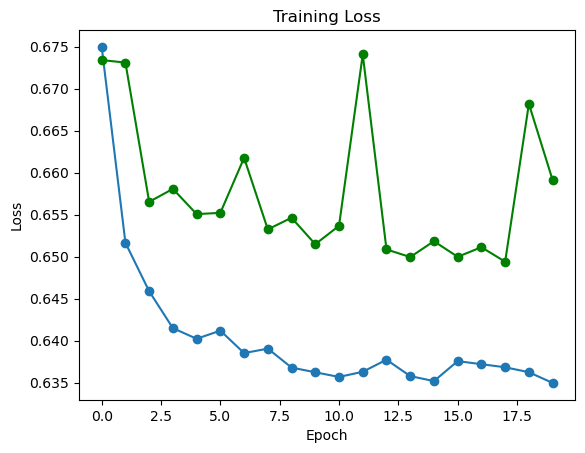

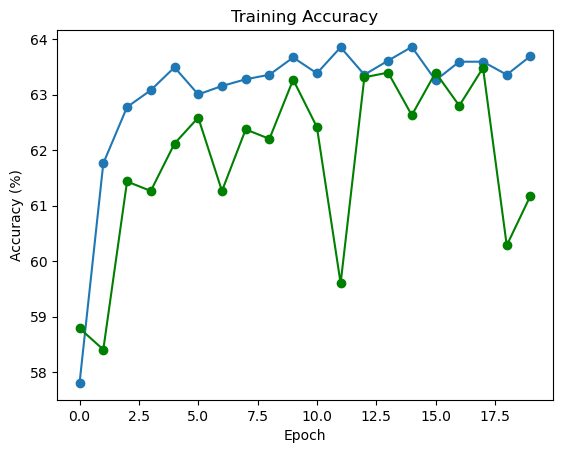

Season 2016 Accuracy: 66.14%


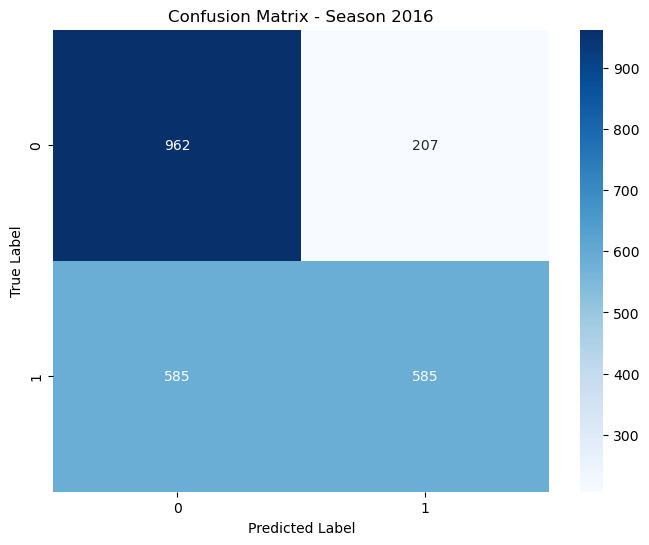

Season 2017 Accuracy: 62.28%


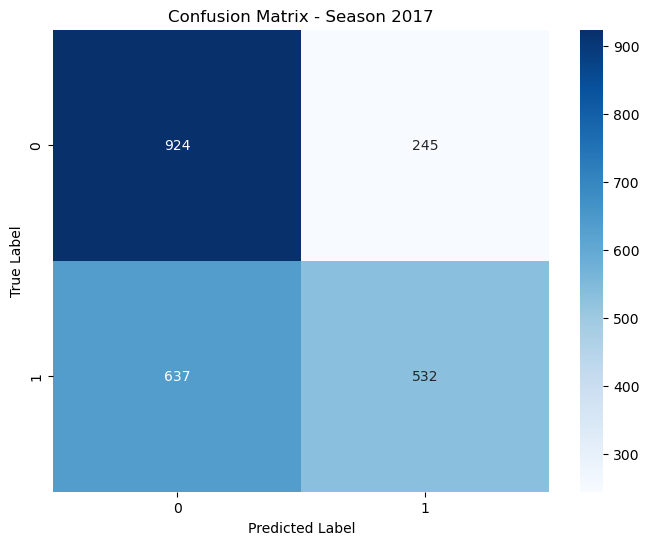

Season 2018 Accuracy: 64.78%


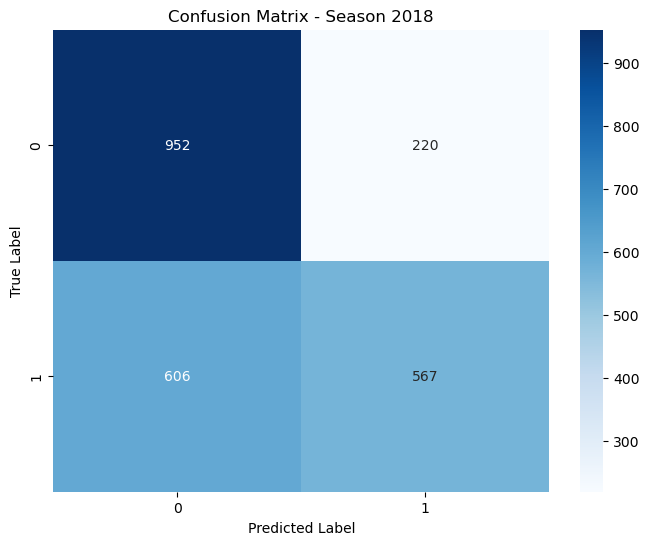

Season 2019 Accuracy: 64.38%


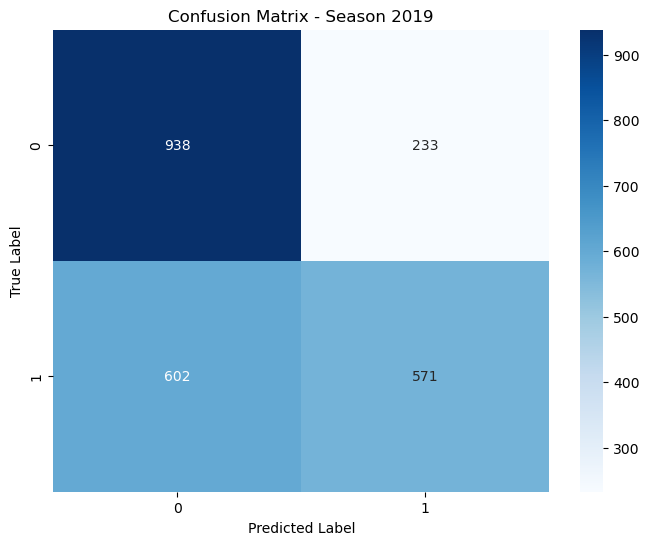

Season 2020 Accuracy: 61.62%


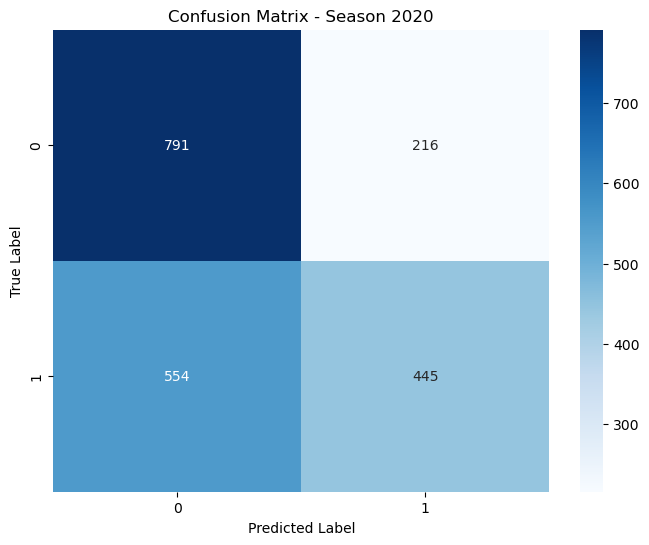

Season 2021 Accuracy: 62.15%


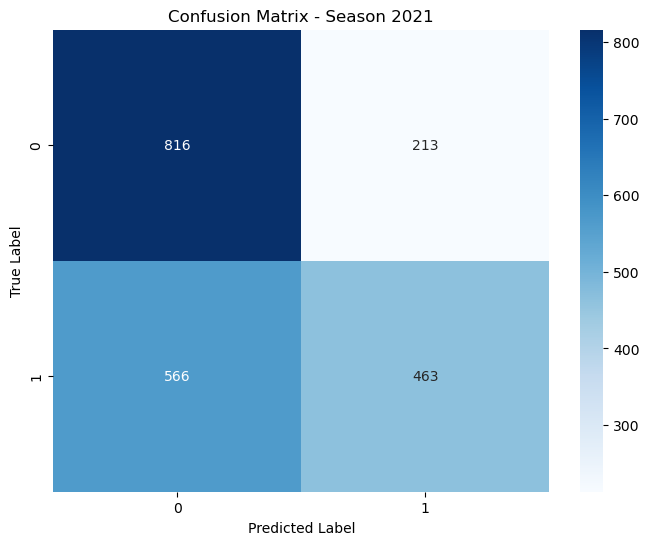

Season 2022 Accuracy: 61.18%


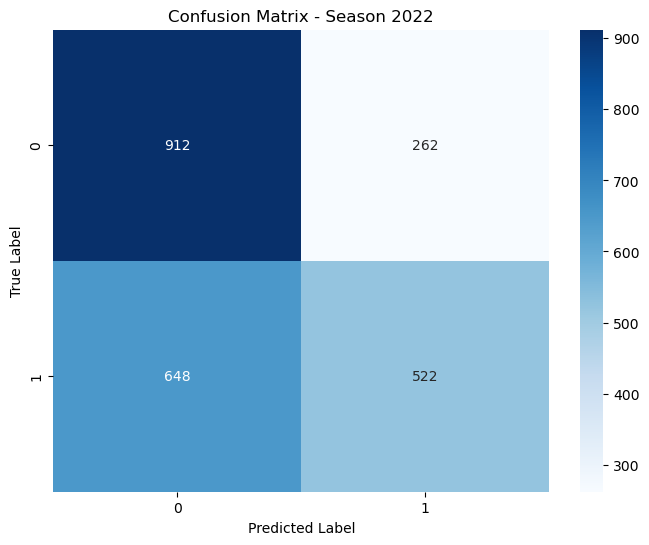

In [7]:


# Initialize the model
input_size = len(features_columns)
print(input_size)
net = SimpleNet(input_size=input_size)

# Train the model
loss_values, accuracy_values, val_loss_values, val_accuracy_values = net.train_model(train_dataloader, test_dataloader, num_epochs=20, lr=0.001)

#Test model

# Plot loss and accuracy
net.plot_loss(loss_values, val_loss_values)
net.plot_accuracy(accuracy_values, val_accuracy_values)

# Perform backtesting
net.backtest(features_df, features_columns)

In [10]:
# Evaluation on testing data
net.eval()
all_labels = []
all_predictions = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        predicted = torch.round(outputs)

        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

        # Collect labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 61.18%


In [11]:
# Specify the path to the prediction dataset
predict_path = 'datasets/predict.csv'
predict_file = os.path.join(os.path.dirname(os.getcwd()), predict_path)

# Load the prediction data
predict_df = pd.read_csv(predict_file)

# Add a target column with all zeros
predict_df['target'] = 0

In [12]:
# Extract features from the prediction dataset
removed_columns = list(predict_df.columns[predict_df.dtypes == "object"])
selected_columns = predict_df.columns[~predict_df.columns.isin(removed_columns)]

# Exclude columns with specific words
excluded_words = ["season", "date", "won", "target", "team", "team_opp"]
features_columns = [col for col in selected_columns if not any(word in col for word in excluded_words)]

predict_features = predict_df[features_columns].values
predict_target = predict_df['target'].values  # Assuming 'target' is the name of your target column

# Create a DataLoader for the prediction data
predict_dataset = NBADataset(predict_features, target=predict_target)
predict_dataloader = DataLoader(predict_dataset, batch_size=32, shuffle=False)

In [13]:
# Assuming both dataframes have the same column names
common_columns = set(predict_df.columns).intersection(processed_df.columns)

# Columns in predict_df but not in processed_df
columns_only_in_predict_df = set(predict_df.columns) - common_columns

# Columns in processed_df but not in predict_df
columns_only_in_processed_df = set(processed_df.columns) - common_columns

print("Columns only in predict_df:", columns_only_in_predict_df)
print("Columns only in processed_df:", columns_only_in_processed_df)


Columns only in predict_df: set()
Columns only in processed_df: {'team_10_x', 'season_10_y', 'team_10_y', 'season_10_x', 'won_10_y'}


In [17]:
# Initialize the model
input_size = len(features_columns)
net = SimpleNet(input_size=input_size)

# Load the saved model state dictionary
model_name = 'files/model_state_dict.pth'
model_path = os.path.join(os.path.dirname(os.getcwd()), model_name)
net.load_state_dict(torch.load(model_path), strict=False)
net.eval()  # Set the model to evaluation mode

# Make predictions
predictions = []

with torch.no_grad():
    for inputs, labels in predict_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        probabilities = outputs.cpu().numpy()  # Get probabilities as NumPy array
        predictions.extend(probabilities)

# Add the probabilities to the original prediction dataframe
predict_df['predicted_probability'] = predictions
predict_df['predicted_result'] = ['Win' if prob > 0.5 else 'Loss' for prob in predictions]

# Display the DataFrame with predicted results
result_df = predict_df[['date_next', 'team_x', 'team_opp_next_x', 'predicted_result', 'predicted_probability', 'season']]

# Create an empty DataFrame to store the game information
game_df = pd.DataFrame(columns=['Team vs Team_Opp', 'Winner', 'Loser', 'Season', 'Date'])

# Initialize variables to keep track of the current game
current_game = 1
current_winner = None

# Loop through the result_df and populate the game_df
for index, row in result_df.iterrows():
    probability = row['predicted_probability'][0]  # Extracting the scalar value

    # Check if it's the first row of a new game
    if index == 0 or row['predicted_result'] == 'Win':
        current_winner = row['team_x']
        game_df.loc[current_game - 1] = {
            'Team vs Team_Opp': f"{row['team_x']} vs {row['team_opp_next_x']}",
            'Winner': "",
            'Loser': "",
            'Season': row['season'],
            'Date': row['date_next']
        }

    # Check if the team won, and only add to the DataFrame if they did
    if row['predicted_result'] == 'Win':
        # Populate the 'Winner' and 'Loser' columns based on the second row of the game
        game_df.loc[current_game - 1, 'Winner'] = f"{current_winner} wins with {probability * 100:.2f}% probability"
        game_df.loc[current_game - 1, 'Loser'] = f"{row['team_opp_next_x']} loses with {100 - probability * 100:.2f}% probability"
        current_game += 1


game_df


,Team vs Team_Opp,Winner,Loser,Season,Date
0,CHA vs MIN,CHA wins with 68.20% probability,MIN loses with 31.80% probability,2023,2023-12-02
1,BKN vs ORL,BKN wins with 55.09% probability,ORL loses with 44.91% probability,2023,2023-12-03
2,DET vs CLE,DET wins with 55.09% probability,CLE loses with 44.91% probability,2023,2023-12-03
3,MIL vs ATL,MIL wins with 64.64% probability,ATL loses with 35.36% probability,2023,2023-12-03
4,DAL vs OKC,DAL wins with 55.13% probability,OKC loses with 44.87% probability,2023,2023-12-03
5,PHX vs MEM,PHX wins with 51.42% probability,MEM loses with 48.58% probability,2023,2023-12-03
6,UTA vs POR,UTA wins with 54.28% probability,POR loses with 45.72% probability,2023,2023-12-03
7,SAC vs DEN,SAC wins with 57.97% probability,DEN loses with 42.03% probability,2023,2023-12-03
8,LAL vs HOU,LAL wins with 55.09% probability,HOU loses with 44.91% probability,2023,2023-12-03


In [19]:
predictions_path = 'datasets/predictions.csv'
predict_file = os.path.join(os.path.dirname(os.getcwd()), predictions_path)
# Save the resulting DataFrame to a new CSV file
game_df.to_csv(predict_file, index=False)